# Proof of concept 

This is a proof of concept for the inclusion of positional uncertainty within the dwell time optimisation algorthim. The focus is on the optimisation method, and as such it is assumed that each seed radially deposits its energy purely based upon the inverse square law.

Two regions are defined, a central target region and a off centre avoid region.

## Initialisation

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from utilities import BasinhoppingWrapper

Create the calculation grid

In [2]:
x_ = np.arange(-1, 1.1, 0.1)
y_ = np.arange(-1, 1.1, 0.1)
z_ = np.arange(-1, 1.1, 0.1)

x, y, z = np.meshgrid(x_, y_, z_)
x = np.ravel(x)
y = np.ravel(y)
z = np.ravel(z)

Define the target and avoid cubes

In [3]:
target_cube = (
    (x < 0.45) & (x > -0.45) & 
    (y < 0.45) & (y > -0.45) & 
    (z < 0.45) & (z > -0.45))

avoid_cube = (
    (x < 0.85) & (x > 0.55) & 
    (y < 0.15) & (y > -0.15) & 
    (z < 0.15) & (z > -0.15))

Display the target and avoid cubes

(-1, 1)

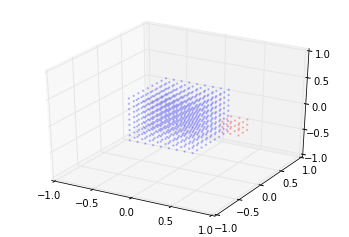

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.2, s=2, color='red')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Create initial equidistant parrallel lines to represent catheters. Inbuild a slight random skew to emulate what occurs physically

In [5]:
number_of_lines = 16

line_start = np.meshgrid(
    [-0.39, -0.13, 0.13, 0.39],
    [-0.39, -0.13, 0.13, 0.39],
    [1])

line_finish = np.array([
    line_start[0] + np.random.normal(scale=0.02, size=[4, 4, 1]),
    line_start[1] + np.random.normal(scale=0.02, size=[4, 4, 1]),
    -line_start[2]])

In [6]:
line_start = np.array([np.ravel(mesh) for mesh in line_start])
line_finish = np.array([np.ravel(mesh) for mesh in line_finish])

Display the lines overlayed

(-1, 1)

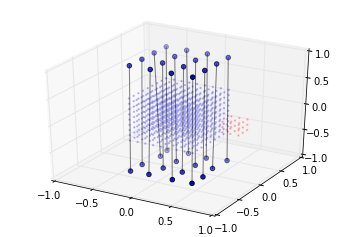

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.2, s=2, color='red')
ax.scatter(*line_start)
ax.scatter(*line_finish)

for i in range(len(line_start[0])):
    plt_coords = [
        [line_start[j][i], line_finish[j][i]]
        for j in range(len(line_start))]
    ax.plot(*plt_coords, color='black', alpha=0.5)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Create a function to return x, y, z coords when a distance along a line is requested

In [8]:
diff = (line_finish - line_start)
line_length = np.sqrt(diff[0]**2 + diff[1]**2 + diff[2]**2)

def find_distance_coords(line_num=None, distance=None):
    relative_dist = distance / line_length[line_num]
    
    if (relative_dist > 1) | (relative_dist < 0):
        return np.array([np.nan]*3)
    
    x = (
        line_start[0][line_num] * (1 - relative_dist) + 
        line_finish[0][line_num] * relative_dist)
    
    y = (
        line_start[1][line_num] * (1 - relative_dist) + 
        line_finish[1][line_num] * relative_dist)
        
    z = (
        line_start[2][line_num] * (1 - relative_dist) + 
        line_finish[2][line_num] * relative_dist)
    
    coords = np.array([x, y, z])
    
    return coords

Pick dwell positons starting at a random position along the line

In [9]:
dwell_spacing = 0.1
dwell_distances_from_initial = np.arange(0, 2, dwell_spacing)
number_of_dwells = len(dwell_distances_from_initial)

In [10]:
inital_dwell_position = np.random.uniform(
    low=0, high=dwell_spacing, size=number_of_lines)
inital_dwell_position

array([ 0.0358412 ,  0.05028099,  0.06534369,  0.0336245 ,  0.0348169 ,
        0.09865868,  0.04009987,  0.09576614,  0.04572926,  0.07226186,
        0.08727153,  0.04457688,  0.06917726,  0.02957117,  0.02166642,
        0.06172738])

In [11]:
dwell_distances = np.reshape(inital_dwell_position, (-1, 1)) + np.reshape(dwell_distances_from_initial, (1, -1))

In [12]:
def find_dwell_coords(line_num=None, dwell_num=None):
    distance = dwell_distances[line_num, dwell_num]
    
    coords = find_distance_coords(
        line_num=line_num, distance=distance)
    
    return coords

Find all the dwell positions that are on the grid

In [13]:
dwell_positions = np.array([
    [
        find_dwell_coords(
            line_num=line_num, dwell_num=dwell_num)
        for dwell_num in range(number_of_dwells)]
 for line_num in range(number_of_lines)])

Plot the dwell positions

In [14]:
line_colours = np.random.uniform(size=(number_of_lines,3))

(-1, 1)

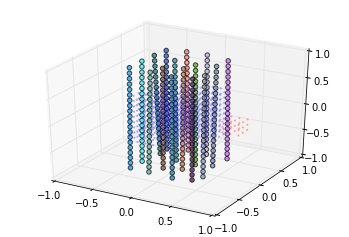

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.2, s=2, color='red')

for line_num in range(number_of_lines):
    ax.scatter(*np.transpose(dwell_positions[line_num]), 
               c=line_colours[line_num], alpha=0.7)


ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Select the dwell positions that fall withing the target region. Only use these dwell positions.

In [16]:
relevant_dwell_positions = np.reshape(dwell_positions, (-1, 3))
keep = ((relevant_dwell_positions[:,0] < 0.45) & 
        (relevant_dwell_positions[:,0] > -0.45) & 
        (relevant_dwell_positions[:,1] < 0.45) & 
        (relevant_dwell_positions[:,1] > -0.45) &
        (relevant_dwell_positions[:,2] < 0.45) & 
        (relevant_dwell_positions[:,2] > -0.45))
relevant_dwell_positions = relevant_dwell_positions[keep]

line_number_index = np.reshape(np.arange(number_of_lines), (number_of_lines, 1))
line_number_index = np.ones([number_of_lines, number_of_dwells]) * line_number_index
line_number_index = np.ravel(line_number_index)[keep]

(-1, 1)

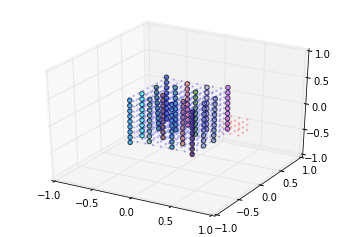

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')

ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.2, s=2, color='red')

for line_num in range(number_of_lines):
    ref = line_number_index == line_num
    ax.scatter(*np.transpose(relevant_dwell_positions[ref]), 
               c=line_colours[line_num], alpha=0.7)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])



## Initial optimisation

Create an array containing the distance to each dwell position for each voxel and translate this to exposure at that voxel per unit dwell time at each dwell position. This is defined in this way so that a reasonable portion of the calculation of exposure can be done outside of the optimisation.

In [18]:
distance_to_dwell_pos = np.array([
    np.sqrt(
        (x[i] - relevant_dwell_positions[:,0])**2 + 
        (y[i] - relevant_dwell_positions[:,1])**2 + 
        (z[i] - relevant_dwell_positions[:,2])**2
    )
    for i in range(len(x))
])

exposure_per_unit_time = 1 / distance_to_dwell_pos**2

Create exposure calculation function

In [19]:
def calculate_exposure(dwell_times):
    exposure = np.sum(dwell_times * exposure_per_unit_time, axis=1)
    
    return exposure

Run a test of arbitrary dwell times

In [20]:
num_relevant_dwells = len(relevant_dwell_positions)

random_pick = np.random.uniform(
    size=2, high=num_relevant_dwells, low=0).astype(int)

dwell_times = np.zeros([1, num_relevant_dwells])
dwell_times[0, random_pick] = 10

exposure = calculate_exposure(dwell_times)

(-1, 1)

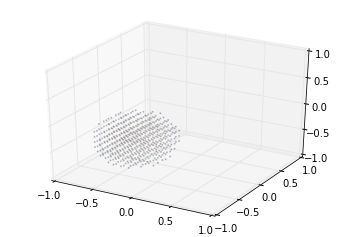

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

reference = exposure > 80
colour = exposure[reference]
colour[colour > 200] = 200

ax.scatter(
    x[reference], y[reference], z[reference], 
    alpha=0.2, s=1, c=colour, cmap=cm.jet)


ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Create function to display the results of the optimisation as it is being calculated.

In [22]:
def display_results(dwell_times):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    reference = exposure > 25
    colour = exposure[reference]
    colour[colour > 100] = 100
    
    small = exposure[reference] < 50
    large = ~small

    ax.scatter(
        x[reference][small], y[reference][small], z[reference][small], 
        alpha=0.2, s=3, c=colour[small], cmap=cm.jet)
    
    ax.scatter(
        x[reference][large], y[reference][large], z[reference][large], 
        alpha=0.4, s=20, c=colour[large], cmap=cm.jet)


    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    cost_function(dwell_times, debug=True)
    
    plt.show()

### Create the optimisation cost function

The maximum exposure to a grid position not within the target is aimed to be less than 120. This cost function aims to achieve this.

(0, 20)

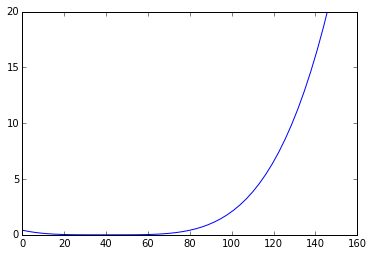

In [23]:
def hot_exterior_cost_function(max_target_exterior):
    return ((max_target_exterior-40)/50)**4

testx = np.linspace(0, 150)
testy = hot_exterior_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 20])

No grid point within the target is to be less than about 50. This cost function aims to achieve this.

(0, 20)

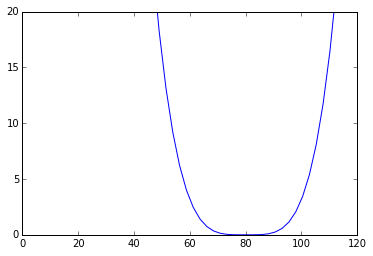

In [24]:
def cold_target_cost_function(min_target):
    return ((min_target-80)/15)**4

testx = np.linspace(0, 120)
testy = cold_target_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 20])

The avoid cost function aims to make no point within the avoid structure more than 40.

(0, 20)

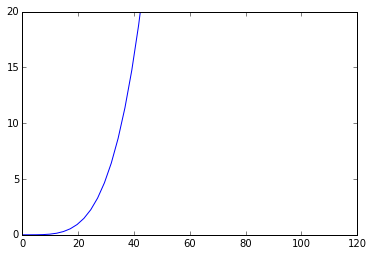

In [25]:
def hot_avoid_cost_function(max_avoid):
    return ((max_avoid)/20)**4

testx = np.linspace(0, 120)
testy = hot_avoid_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 20])

Create the cost function to be used by the optimiser

In [26]:
def cost_function(dwell_times, debug=False):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    min_target = np.min(exposure[target_cube])
    max_avoid = np.max(exposure[avoid_cube])
    max_target_exterior = np.max(exposure[~target_cube])
    
    cold_target_cost = cold_target_cost_function(min_target)
    hot_exterior_cost = hot_exterior_cost_function(max_target_exterior)
    hot_avoid_cost = hot_avoid_cost_function(max_avoid)
    
    total_cost = hot_exterior_cost + cold_target_cost + hot_avoid_cost
    
    if debug:
        print("Minimum target = %0.4f, resulting cost = %0.4f" %
              (min_target, cold_target_cost))
        print("Maximum exterior = %0.4f, resulting cost = %0.4f" %
              (max_target_exterior, hot_exterior_cost))
        print("Maximum avoid = %0.4f, resulting cost = %0.4f" %
              (max_avoid, hot_avoid_cost))
        print("Total cost = %0.4f" % (total_cost))
        
    
    return total_cost

Create initial conditions

In [27]:
num_relevant_dwells

144

In [28]:
initial_conditions = np.ones(num_relevant_dwells)*0.1

Step noise

In [29]:
step_noise = np.ones(num_relevant_dwells) * 0.3

Bounds

In [30]:
bounds = ((0, None),)*num_relevant_dwells

Run the optimiser

Minimum target = 58.5850, resulting cost = 4.1544
Maximum exterior = 100.4528, resulting cost = 2.1369
Maximum avoid = 36.0211, resulting cost = 10.5223
Total cost = 16.8135


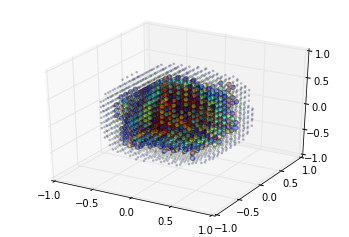

Minimum target = 59.9402, resulting cost = 3.1985
Maximum exterior = 101.0413, resulting cost = 2.2213
Maximum avoid = 37.3478, resulting cost = 12.1602
Total cost = 17.5800


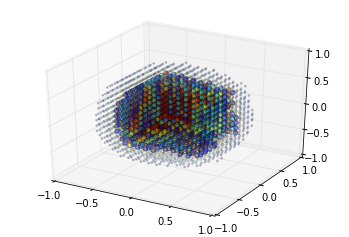

Minimum target = 59.0523, resulting cost = 3.8035
Maximum exterior = 84.5627, resulting cost = 0.6310
Maximum avoid = 36.7688, resulting cost = 11.4235
Total cost = 15.8579


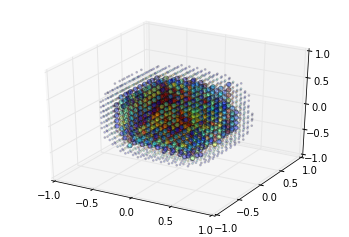

Minimum target = 59.0327, resulting cost = 3.8177
Maximum exterior = 103.2804, resulting cost = 2.5656
Maximum avoid = 36.1836, resulting cost = 10.7134
Total cost = 17.0967


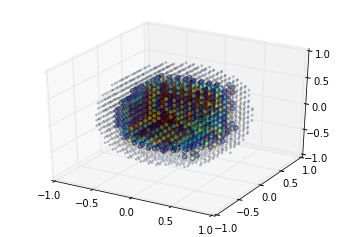

Minimum target = 59.1270, resulting cost = 3.7495
Maximum exterior = 92.8462, resulting cost = 1.2479
Maximum avoid = 36.7578, resulting cost = 11.4098
Total cost = 16.4072


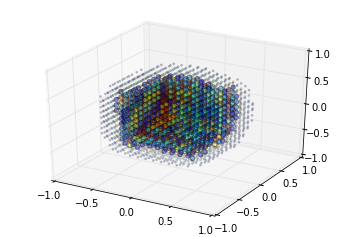

Minimum target = 58.3276, resulting cost = 4.3577
Maximum exterior = 85.6369, resulting cost = 0.6940
Maximum avoid = 36.1207, resulting cost = 10.6391
Total cost = 15.6909


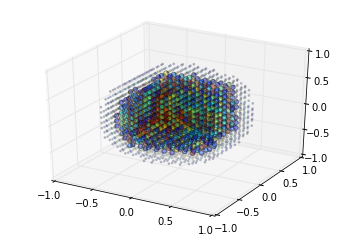

Minimum target = 55.9823, resulting cost = 6.5729
Maximum exterior = 103.2807, resulting cost = 2.5657
Maximum avoid = 35.5838, resulting cost = 10.0205
Total cost = 19.1591


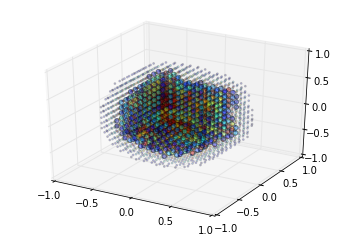

Minimum target = 58.3403, resulting cost = 4.3476
Maximum exterior = 96.5768, resulting cost = 1.6394
Maximum avoid = 37.8482, resulting cost = 12.8251
Total cost = 18.8120


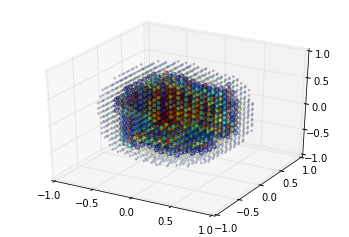

Minimum target = 58.1922, resulting cost = 4.4677
Maximum exterior = 84.8309, resulting cost = 0.6463
Maximum avoid = 35.7549, resulting cost = 10.2146
Total cost = 15.3285


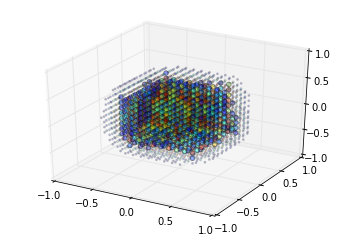

Minimum target = 59.8946, resulting cost = 3.2276
Maximum exterior = 88.4410, resulting cost = 0.8810
Maximum avoid = 36.1808, resulting cost = 10.7101
Total cost = 14.8187


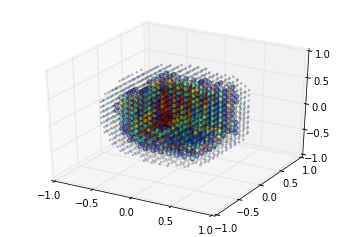

Minimum target = 57.2967, resulting cost = 5.2479
Maximum exterior = 98.7762, resulting cost = 1.9095
Maximum avoid = 36.8277, resulting cost = 11.4969
Total cost = 18.6544


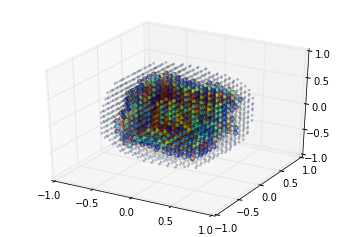

Minimum target = 59.4291, resulting cost = 3.5371
Maximum exterior = 92.2473, resulting cost = 1.1923
Maximum avoid = 35.9643, resulting cost = 10.4560
Total cost = 15.1854


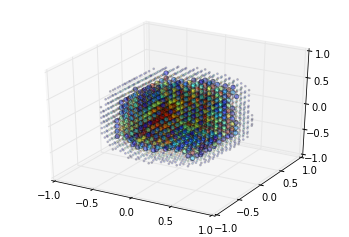

Minimum target = 53.5903, resulting cost = 9.6093
Maximum exterior = 105.3249, resulting cost = 2.9136
Maximum avoid = 35.5796, resulting cost = 10.0158
Total cost = 22.5387


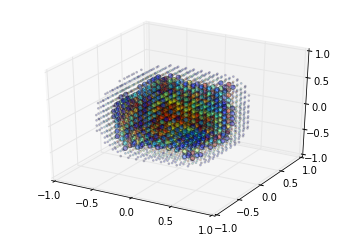

Minimum target = 57.4442, resulting cost = 5.1129
Maximum exterior = 95.2564, resulting cost = 1.4916
Maximum avoid = 35.6558, resulting cost = 10.1018
Total cost = 16.7063


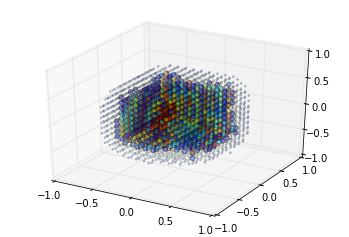

Minimum target = 59.3503, resulting cost = 3.5916
Maximum exterior = 94.5924, resulting cost = 1.4212
Maximum avoid = 36.6988, resulting cost = 11.3367
Total cost = 16.3495


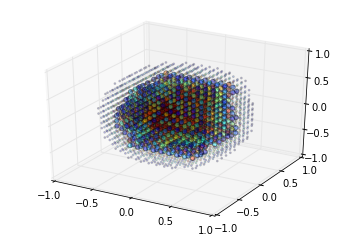

Minimum target = 29.8225, resulting cost = 125.2191
Maximum exterior = 364.8419, resulting cost = 1781.5909
Maximum avoid = 41.3488, resulting cost = 18.2696
Total cost = 1925.0796


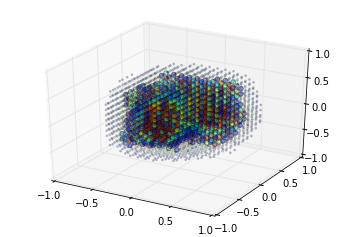

Minimum target = 58.7891, resulting cost = 3.9983
Maximum exterior = 82.4034, resulting cost = 0.5173
Maximum avoid = 35.8325, resulting cost = 10.3036
Total cost = 14.8191


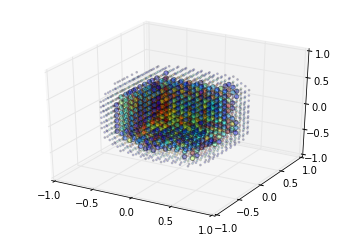

Minimum target = 58.2496, resulting cost = 4.4208
Maximum exterior = 82.7004, resulting cost = 0.5319
Maximum avoid = 35.8331, resulting cost = 10.3043
Total cost = 15.2570


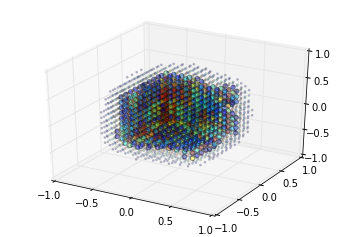

Minimum target = 57.0846, resulting cost = 5.4469
Maximum exterior = 96.5042, resulting cost = 1.6310
Maximum avoid = 36.3052, resulting cost = 10.8581
Total cost = 17.9359


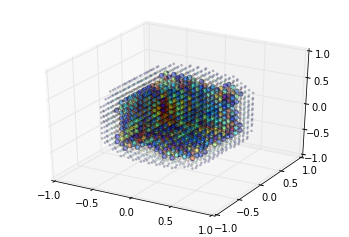

Minimum target = 59.2553, resulting cost = 3.6581
Maximum exterior = 79.5148, resulting cost = 0.3901
Maximum avoid = 35.9124, resulting cost = 10.3958
Total cost = 14.4440


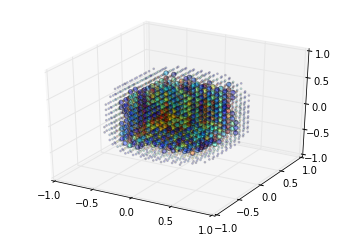

In [31]:
optimisation = BasinhoppingWrapper(
    to_minimise=cost_function,
    initial=initial_conditions,
    step_noise=step_noise,
    basinhopping_confidence=2,
    optimiser_confidence=0.0001,
    n=5,
    debug=display_results,
    bounds=bounds
)

## Presentation of results

Minimum target = 60.0782, resulting cost = 3.1114
Maximum exterior = 70.6273, resulting cost = 0.1408
Maximum avoid = 35.6067, resulting cost = 10.0463
Total cost = 13.2984


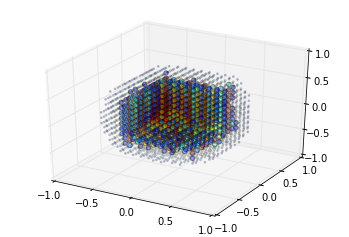

In [32]:
display_results(optimisation.result)

Display histogram of resulting dwell times

(array([  6.,   7.,   8.,  22.,  80.,   8.,   7.,   3.,   2.,   1.]),
 array([ 0.01708583,  0.0375252 ,  0.05796457,  0.07840394,  0.09884331,
         0.11928268,  0.13972206,  0.16016143,  0.1806008 ,  0.20104017,
         0.22147954]),
 <a list of 10 Patch objects>)

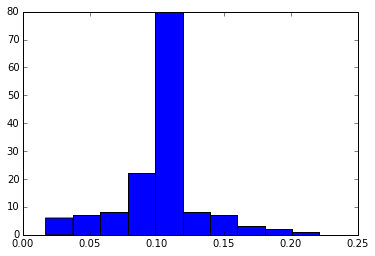

In [33]:
plt.hist(optimisation.result)

Give overview of dwell times segmented by catheter

Line number 0


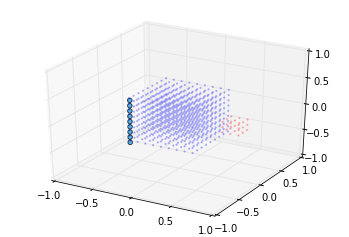

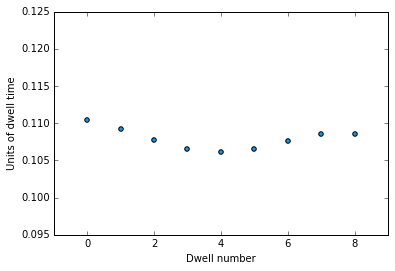

Line number 1


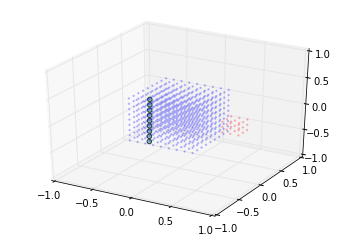

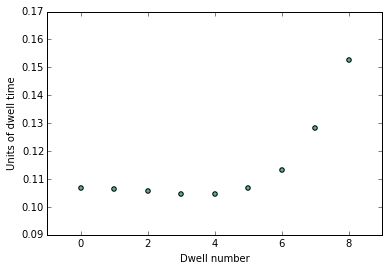

Line number 2


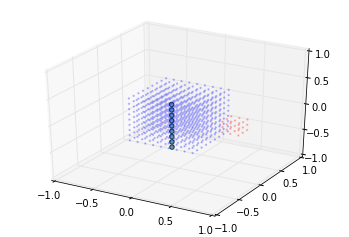

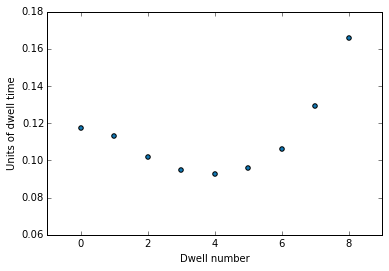

Line number 3


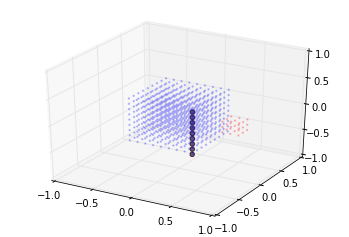

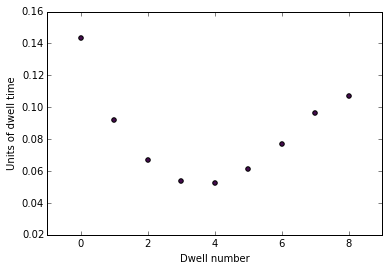

Line number 4


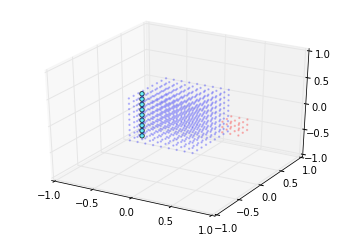

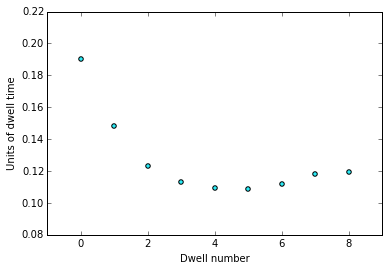

Line number 5


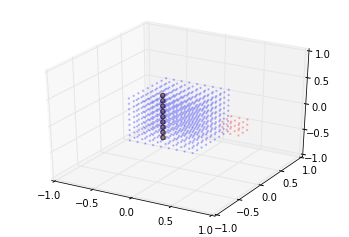

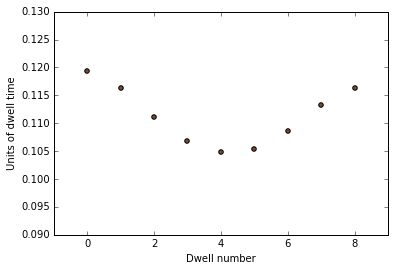

Line number 6


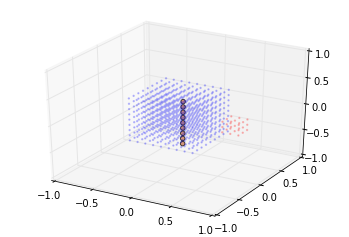

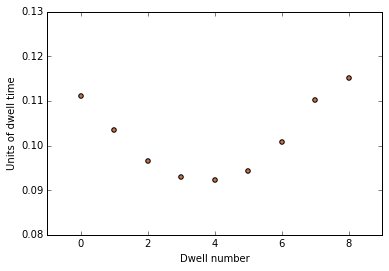

Line number 7


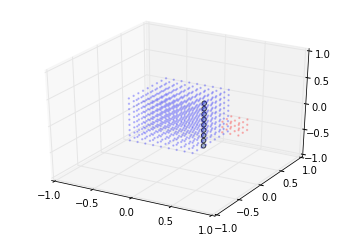

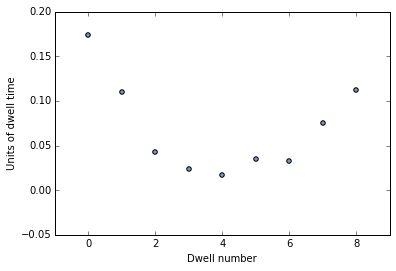

Line number 8


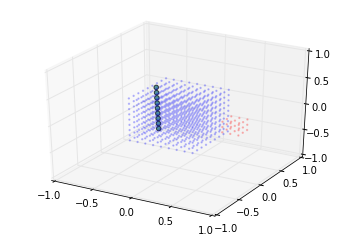

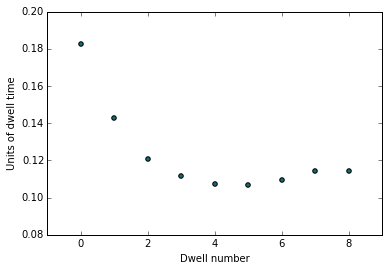

Line number 9


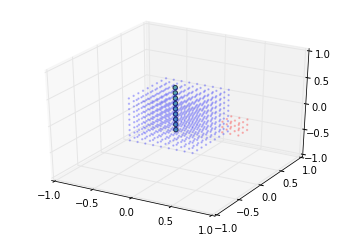

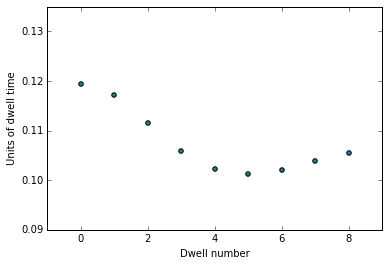

Line number 10


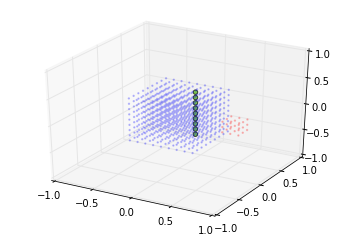

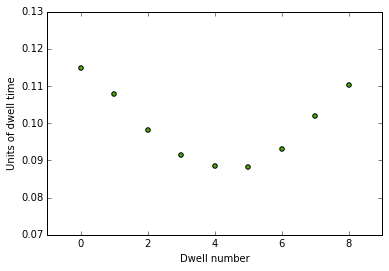

Line number 11


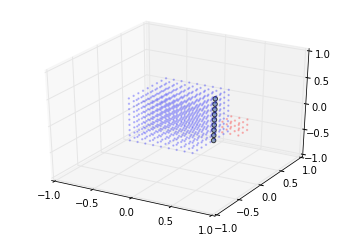

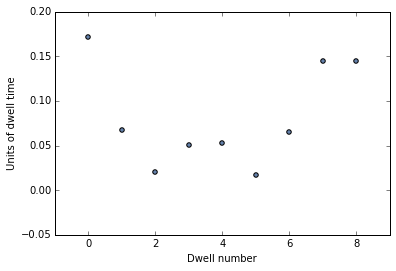

Line number 12


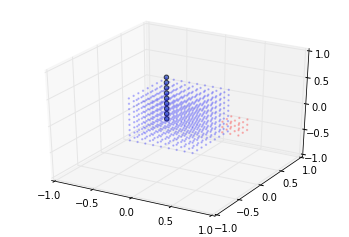

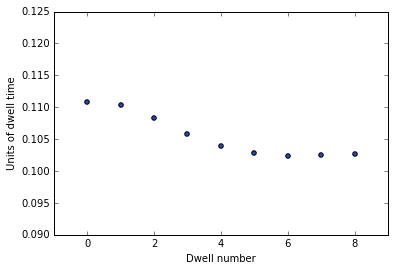

Line number 13


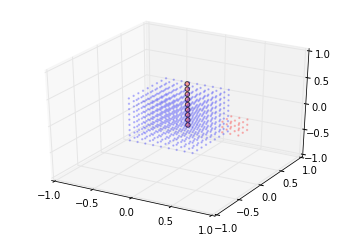

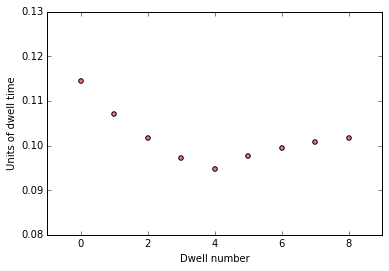

Line number 14


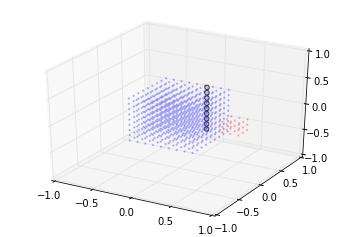

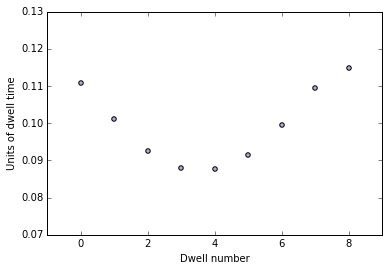

Line number 15


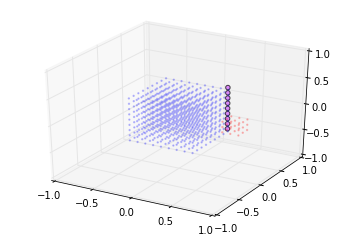

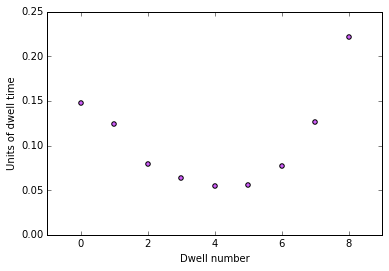

In [34]:
for line_num in range(number_of_lines):
    
    print("Line number %d" % (line_num))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        x[target_cube], y[target_cube], z[target_cube], 
        alpha=0.2, s=2, color='blue')
    ax.scatter(
        x[avoid_cube], y[avoid_cube], z[avoid_cube], 
        alpha=0.2, s=2, color='red')
    
    ref = line_number_index == line_num
    ax.scatter(*np.transpose(relevant_dwell_positions[ref]), 
               c=line_colours[line_num], alpha=0.7)


    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    plt.show() 
    
    
    plt.scatter(np.arange(np.sum(ref)), optimisation.result[ref],
               c=line_colours[line_num])
    plt.xlabel("Dwell number")
    plt.ylabel("Units of dwell time")
    plt.show()

Convert result into column vector for post analysis

In [35]:
dwell_times = np.reshape(optimisation.result, (1, num_relevant_dwells))

Create a custom resolution exposure calculation function for post analysis

In [36]:
def create_calculate_exposure(dwell_positions, dx=0.1, dy=0.1, dz=0.1):
    x_ = np.arange(-1, 1 + dx, dx)
    y_ = np.arange(-1, 1 + dy, dy)
    z_ = np.arange(-1, 1 + dz, dz)

    x, y, z = np.meshgrid(
        x_, y_, z_)
    x = np.ravel(x)
    y = np.ravel(y)
    z = np.ravel(z)

    distance_to_dwell_pos = np.array([
        np.sqrt(
            (x[i] - dwell_positions[:,0])**2 + 
            (y[i] - dwell_positions[:,1])**2 + 
            (z[i] - dwell_positions[:,2])**2
        )
        for i in range(len(x))
    ])

    exposure_per_unit_time = 1 / distance_to_dwell_pos**2
    
    def calculate_exposure(dwell_times):
        exposure = np.sum(dwell_times * exposure_per_unit_time, axis=1)
        return exposure
        
    return calculate_exposure

In [37]:
contour_calculate_exposure = create_calculate_exposure(
    relevant_dwell_positions, dx=0.01, dy=0.01)

contour_exposure = contour_calculate_exposure(dwell_times)

contour_exposure = np.reshape(contour_exposure, (
    201, 201, 21))
contour_exposure[contour_exposure > 250] = 250

contour_x_ = np.arange(-1, 1 + 0.01, 0.01)
contout_y_ = np.arange(-1, 1 + 0.01, 0.01)

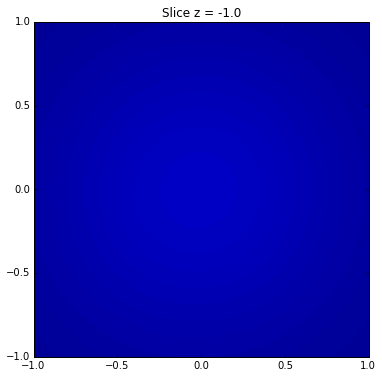

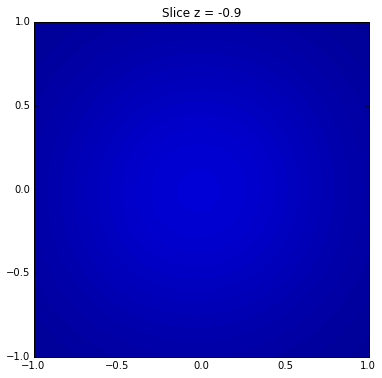

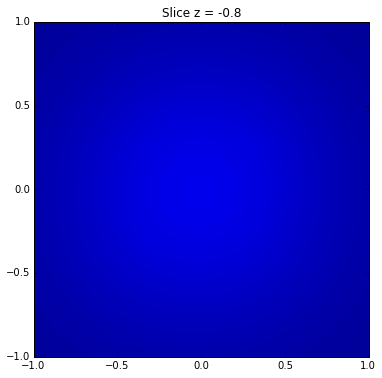

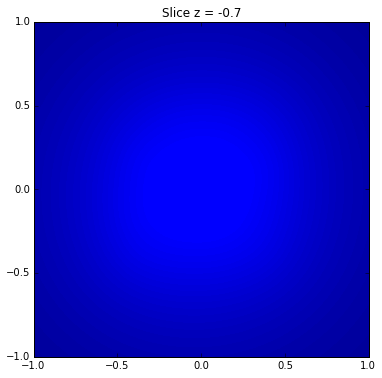

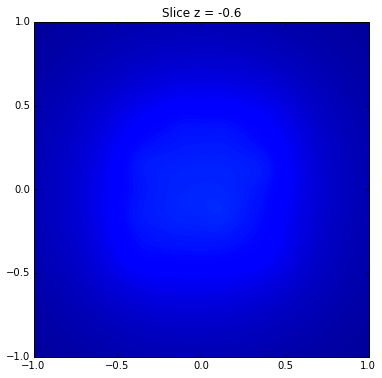

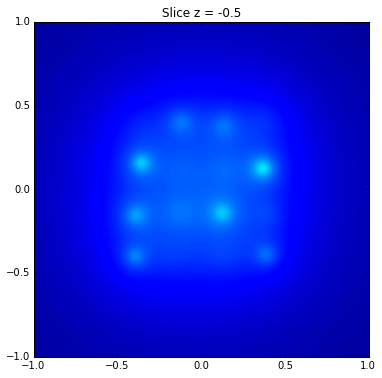

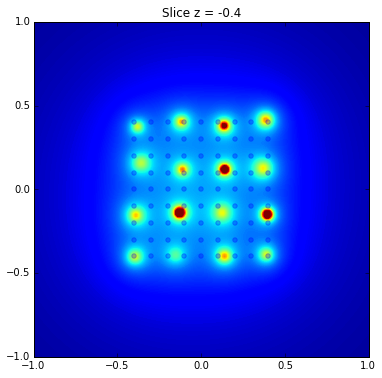

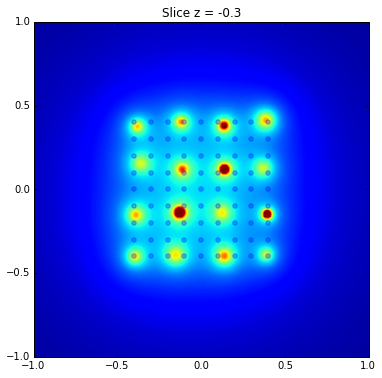

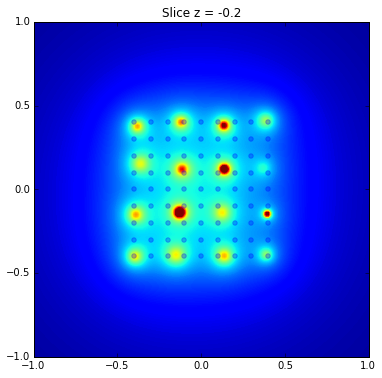

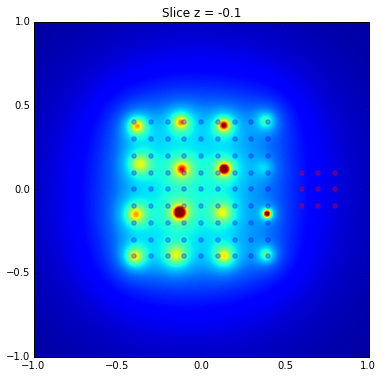

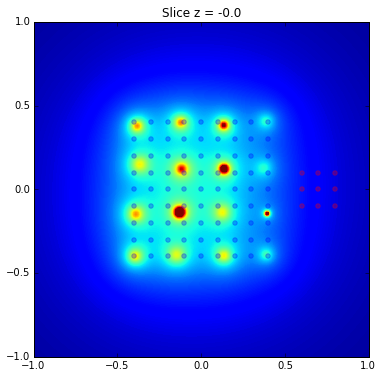

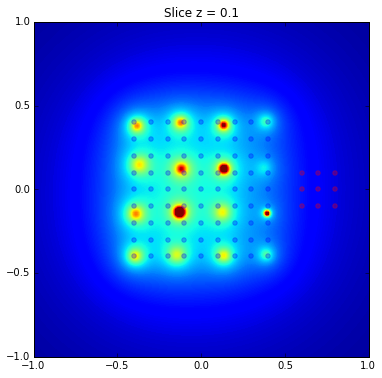

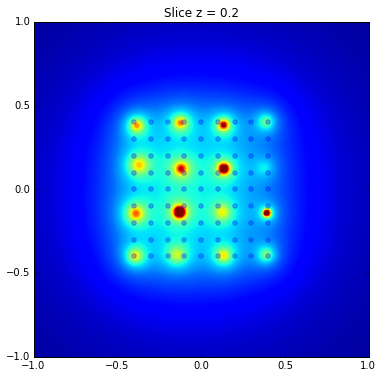

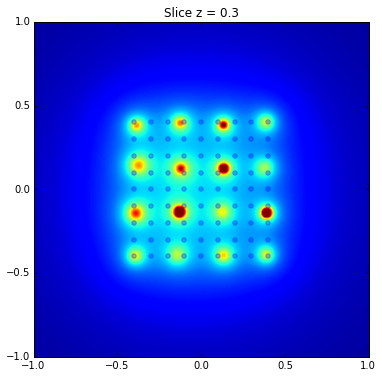

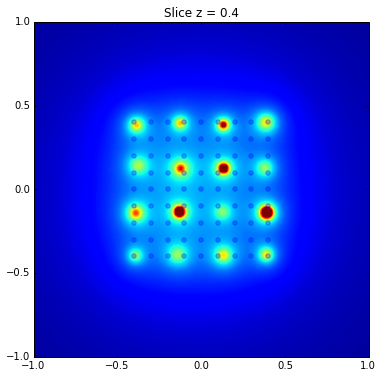

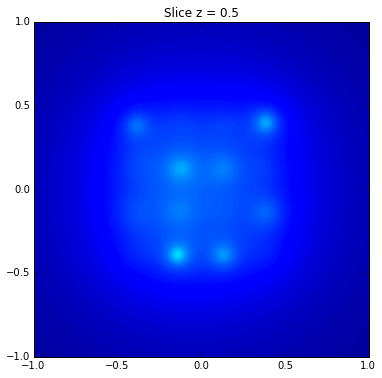

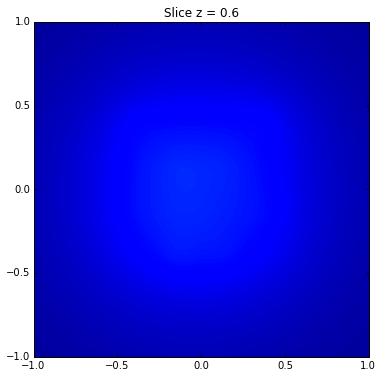

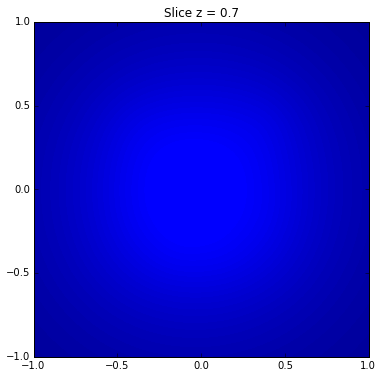

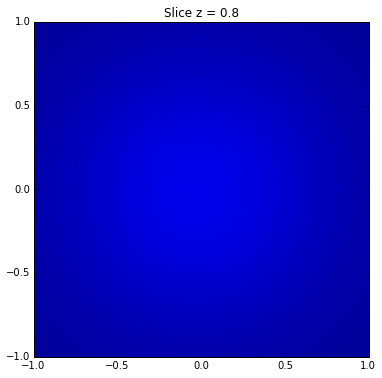

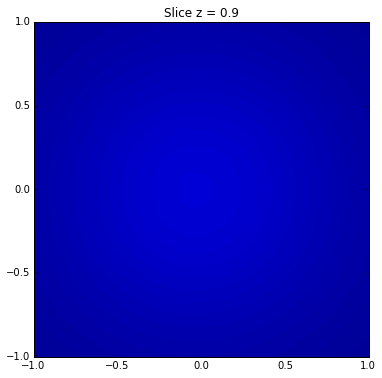

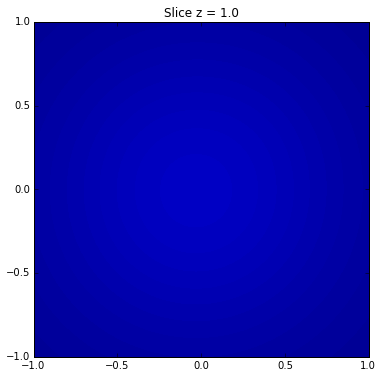

In [38]:
for i in range(21):
    plt.figure(figsize=(6,6))
    
    c = plt.contourf(contour_x_, contout_y_,
        contour_exposure[:, :, i], 250,
        vmin=0, vmax=250)
    
    reference = z[target_cube] == z_[i]
    x_target = x[target_cube][reference]
    y_target = y[target_cube][reference]
    plt.scatter(x_target, y_target, alpha=0.3, color='blue')
    
    reference = z[avoid_cube] == z_[i]
    x_avoid = x[avoid_cube][reference]
    y_avoid = y[avoid_cube][reference]
    plt.scatter(x_avoid, y_avoid, alpha=0.3, color='red')
    
    plt.title("Slice z = %0.1f" % (z_[i]))
#     plt.colorbar(c)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.show()

## Analysis of results

Create analysis grid

In [39]:
dx = 0.02
dy = 0.02
dz = 0.02

post_x_ = np.arange(-1, 1 + dx, dx)
post_y_ = np.arange(-1, 1 + dy, dy)
post_z_ = np.arange(-1, 1 + dz, dz)

post_x, post_y, post_z = np.meshgrid(
    post_x_, post_y_, post_z_)
post_x = np.ravel(post_x)
post_y = np.ravel(post_y)
post_z = np.ravel(post_z)

post_calculate_exposure = create_calculate_exposure(
    relevant_dwell_positions, dx=dx, dy=dy, dz=dz)

post_exposure = post_calculate_exposure(dwell_times)

Define structures on new finer grid

In [40]:
post_target_cube = (
    (post_x < 0.45) & (post_x > -0.45) & 
    (post_y < 0.45) & (post_y > -0.45) & 
    (post_z < 0.45) & (post_z > -0.45))

post_avoid_cube = (
    (post_x < 0.85) & (post_x > 0.55) & 
    (post_y < 0.15) & (post_y > -0.15) & 
    (post_z < 0.15) & (post_z > -0.15))

Make a function to plot DVHs given a reference

In [41]:
def create_dvh(reference, exposure, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    
    results = exposure[reference]
    results[results>150] = 150
    hist = np.histogram(results, 100)
    
    freq = hist[0]
    bin_edge = hist[1]
    bin_mid = (bin_edge[1::] + bin_edge[:-1:])/2
    
    cumulative = np.cumsum(freq[::-1])
    cumulative = cumulative[::-1]
    bin_mid = np.append([0], bin_mid)
    
    cumulative = np.append(cumulative[0], cumulative)
    percent_cumulative = cumulative / cumulative[0] * 100

    ax.plot(bin_mid, percent_cumulative)

Plotting of relevant DVHs

(0, 150)

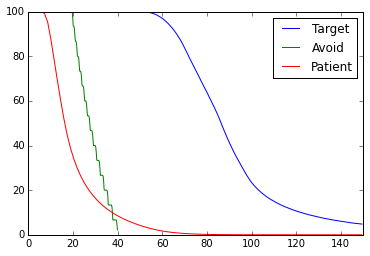

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

create_dvh(post_target_cube, post_exposure, ax=ax)
create_dvh(post_avoid_cube, post_exposure, ax=ax)
create_dvh(~post_target_cube, post_exposure, ax=ax)

plt.legend(["Target", "Avoid", "Patient"])

plt.xlim([0, 150])

Add a random shift to each catheter, see the effect it has on target DVH.

In [43]:
relevant_dwell_distances = np.ravel(dwell_distances)[keep]
shift_uncertainty = 0.05

In [44]:
line_displacement = np.random.normal(scale=shift_uncertainty, size=number_of_lines)

In [45]:
shifted_dwell_positions = np.array([
    find_distance_coords(
        distance=relevant_dwell_distances[i] + line_displacement[line_number_index[i]], 
        line_num=line_number_index[i])
    for i in range(len(relevant_dwell_distances))
])

In [46]:
shifted_calculate_exposure = create_calculate_exposure(
    shifted_dwell_positions, dx=dx, dy=dy, dz=dz)

shifted_exposure = shifted_calculate_exposure(dwell_times)

With the shift the change in the DVH is the following. For the optimisation given here there is very little change in DVH.

(0, 110)

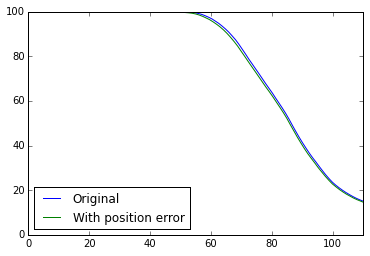

In [47]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

create_dvh(post_target_cube, post_exposure, ax=ax)
create_dvh(post_target_cube, shifted_exposure, ax=ax)

plt.legend(["Original", "With position error"], loc='lower left')

plt.xlim([0, 110])

## New optimisation with included shifts

An example of how the optimisation could be made to include positional uncertainty as one of its factors.

To test the ability to reduce positional effects magnitude of the uncertainty is increased. Without this increase there is little to no need to actually do this positional correction due to the initial optimisation producing a well behaved result.

In [48]:
shift_uncertainty = 0.2

Create shifted exposure function

In [49]:
def create_shifted_exposure(dx=0.1, dy=0.1, dz=0.1):
    line_displacement = np.random.normal(
        scale=shift_uncertainty, size=number_of_lines)
    
    shifted_dwell_positions = np.array([
        find_distance_coords(
            distance=relevant_dwell_distances[i] + line_displacement[line_number_index[i]], 
            line_num=line_number_index[i])
        for i in range(len(relevant_dwell_distances))
    ])
    
    shifted_calculate_exposure = create_calculate_exposure(
        shifted_dwell_positions, dx=dx, dy=dy, dz=dz)

    return shifted_calculate_exposure

New shifted exposure plot (with amplified positional uncertainty)

In [50]:
amplified_shifted_exposure_function = create_shifted_exposure(dx=0.02, dy=0.02, dz=0.02)
amplified_shifted_exposure = amplified_shifted_exposure_function(dwell_times)

(0, 110)

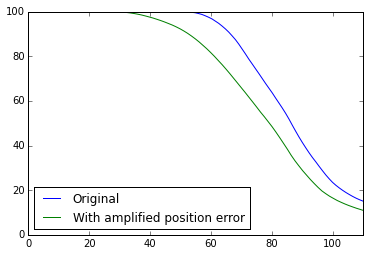

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

create_dvh(post_target_cube, post_exposure, ax=ax)
create_dvh(post_target_cube, amplified_shifted_exposure, ax=ax)

plt.legend(["Original", "With amplified position error"], loc='lower left')

plt.xlim([0, 110])

Create a range of exposure calculation functions given a random shift in dwell position.

In [54]:
number_of_shifted = 21
shifted_exposure_functions = [
    create_shifted_exposure() for i in range(number_of_shifted)]

In [55]:
for i in range(number_of_shifted):
    exposure = shifted_exposure_functions[i](dwell_times)
    assert np.sum(np.isnan(exposure)) == 0 # Stop if there are any nans. Fix the nan creation later.

Create the new cost function which is not only based upon the original dwell postions, but also takes into accout the shifts define just above.

In [56]:
def cost_function_with_shifts(dwell_times, debug=False):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    min_target_original = np.min(exposure[target_cube])
    max_avoid_original = np.max(exposure[avoid_cube])
    max_target_exterior_original = np.max(exposure[~target_cube])
    
    cold_target_cost = cold_target_cost_function(min_target_original)
    hot_exterior_cost = hot_exterior_cost_function(max_target_exterior_original)
    hot_avoid_cost = hot_avoid_cost_function(max_avoid_original)
    
    for i in range(number_of_shifted):
        exposure = shifted_exposure_functions[i](dwell_times)
        
        min_target = np.min(exposure[target_cube])
        max_avoid = np.max(exposure[avoid_cube])
        max_target_exterior = np.max(exposure[~target_cube])
        
        cold_target_cost = (
            cold_target_cost + cold_target_cost_function(min_target))          
        hot_exterior_cost = (
            hot_exterior_cost + hot_exterior_cost_function(max_target_exterior))
        hot_avoid_cost = (
            hot_avoid_cost + hot_avoid_cost_function(max_avoid))
    
    cold_target_cost = cold_target_cost / (number_of_shifted + 1)
    hot_exterior_cost = hot_exterior_cost / (number_of_shifted + 1)
    hot_avoid_cost = hot_avoid_cost / (number_of_shifted + 1)    
    
    total_cost = hot_exterior_cost + cold_target_cost + hot_avoid_cost
            
    if debug:
        print("Minimum target = %0.4f, resulting cost = %0.4f" %
              (min_target_original, cold_target_cost))
        print("Maximum exterior = %0.4f, resulting cost = %0.4f" %
              (max_target_exterior_original, hot_exterior_cost))
        print("Maximum avoid = %0.4f, resulting cost = %0.4f" %
              (max_avoid_original, hot_avoid_cost))
        print("Total cost = %0.4f" % (total_cost))
        
    
    return total_cost

The new display results function

In [ ]:
def display_results_with_shifts(dwell_times):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    reference = exposure > 25
    colour = exposure[reference]
    colour[colour > 100] = 100
    
    small = exposure[reference] < 50
    large = ~small

    ax.scatter(
        x[reference][small], y[reference][small], z[reference][small], 
        alpha=0.2, s=3, c=colour[small], cmap=cm.jet)
    
    ax.scatter(
        x[reference][large], y[reference][large], z[reference][large], 
        alpha=0.4, s=20, c=colour[large], cmap=cm.jet)


    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    cost_function_with_shifts(dwell_times, debug=True)
    
    plt.show()

Run the optimisation.

In [ ]:
optimisation_with_shifts = BasinhoppingWrapper(
    to_minimise=cost_function_with_shifts,
    initial=optimisation.result,
    step_noise=step_noise,
    basinhopping_confidence=2,
    optimiser_confidence=0.0001,
    n=5,
    debug=display_results_with_shifts,
    bounds=bounds
)

Present the results

In [ ]:
plt.hist(optimisation_with_shifts.result)

In [ ]:
for line_num in range(number_of_lines):
    
    print("Line number %d" % (line_num))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        x[target_cube], y[target_cube], z[target_cube], 
        alpha=0.2, s=2, color='blue')
    ax.scatter(
        x[avoid_cube], y[avoid_cube], z[avoid_cube], 
        alpha=0.2, s=2, color='red')
    
    ref = line_number_index == line_num
    ax.scatter(*np.transpose(relevant_dwell_positions[ref]), 
               c=line_colours[line_num], alpha=0.7)


    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    plt.show() 
    
    
    plt.scatter(np.arange(np.sum(ref)), optimisation_with_shifts.result[ref],
               c=line_colours[line_num])
    plt.xlabel("Dwell number")
    plt.ylabel("Units of dwell time")
    plt.show()

In [ ]:
dwell_times_with_shifts = np.reshape(optimisation_with_shifts.result, (1, num_relevant_dwells))

In [ ]:
contour_exposure_with_shift = contour_calculate_exposure(dwell_times_with_shifts)

contour_exposure_with_shift = np.reshape(contour_exposure_with_shift, (
    201, 201, 21))
contour_exposure_with_shift[contour_exposure_with_shift > 250] = 250

for i in range(21):
    plt.figure(figsize=(6,6))
    
    c = plt.contourf(contour_x_, contout_y_,
        contour_exposure_with_shift[:, :, i], 250,
        vmin=0, vmax=250)
    
    reference = z[target_cube] == z_[i]
    x_target = x[target_cube][reference]
    y_target = y[target_cube][reference]
    plt.scatter(x_target, y_target, alpha=0.3, color='blue')
    
    reference = z[avoid_cube] == z_[i]
    x_avoid = x[avoid_cube][reference]
    y_avoid = y[avoid_cube][reference]
    plt.scatter(x_avoid, y_avoid, alpha=0.3, color='red')
    
    plt.title("Slice z = %0.1f" % (z_[i]))
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.show()

In [ ]:
post_exposure_with_shifts = post_calculate_exposure(dwell_times_with_shifts)
shifted_exposure_with_shifts = amplified_shifted_exposure_function(dwell_times_with_shifts)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

create_dvh(post_target_cube, post_exposure, ax=ax)
create_dvh(post_target_cube, shifted_exposure, ax=ax)
create_dvh(post_target_cube, post_exposure_with_shifts, ax=ax)
create_dvh(post_target_cube, shifted_exposure_with_shifts, ax=ax)

create_dvh(post_avoid_cube, post_exposure, ax=ax)
create_dvh(post_avoid_cube, post_exposure_with_shifts, ax=ax)

create_dvh(~post_target_cube, post_exposure, ax=ax)
create_dvh(~post_target_cube, post_exposure_with_shifts, ax=ax)

plt.legend([
        "Old without shift",
        "Old with shift",
        "New without shift", 
        "New with shift"], loc="lower left")

plt.xlim([0, 150])

When including the positional error able to achieve what was originally expected after a shift. Comes at cost of everything being allround hotter.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

create_dvh(post_target_cube, post_exposure, ax=ax)
create_dvh(post_target_cube, shifted_exposure, ax=ax)
create_dvh(post_target_cube, post_exposure_with_shifts, ax=ax)
create_dvh(post_target_cube, shifted_exposure_with_shifts, ax=ax)

plt.legend([
        "Old without shift",
        "Old with shift",
        "New without shift", 
        "New with shift"], loc="lower left")

plt.xlim([40, 70])
plt.ylim([80, 100])